<a href="https://colab.research.google.com/github/shubham-pyc/RL/blob/main/Copy_of_Blackjack_Q_Table_Backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gym

# Gym Environment

In [ ]:
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
environment = gym.make(
    "Blackjack-v1",   # environment name
    natural=True,     # flag to payout 1.5x on a "natural" blackjack win
    new_step_api=True # avoids warnings and allows future compatibility
)

# Agent

In [ ]:
class Agent(object):

    def __init__(self):
        self.quality_table = np.ones(shape=(32, 11, 2, 2))*5.0

    def act(self, observation):
        observation = self._clean_state(observation)
        return np.argmax(self.quality_table[observation])

    def act_greedy(self, observation):
        observation = self._clean_state(observation)
        return np.argmax(self.quality_table[observation])

    def estimateQ(self, observation):
        observation = self._clean_state(observation)
        return np.max(self.quality_table[observation])

    def update(self, state, action, target):
        state = self._clean_state(state)
        self.quality_table[state + (action,)] += (target - self.quality_table[state + (action,)]) *0.0002

    # cast (10, 5, True) -> np.array([10, 5, 1]) -> (10, 5, 1)
    def _clean_state(self, observation):
        return tuple(np.array(observation))

# Use Monte Carlo control to learn a near-optimal policy

In [ ]:
# 
agent = Agent()
downSample = 50_000
winRate_down = [] #record the win-rate every downSample episodes
results = []

for iteration in range(1_000_000): #20_000_000):
    state = environment.reset()
    done = False
    states, actions, rewards = [], [], []
    # Create an episode by interacting with the environment
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = environment.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        state = next_state
    # work back from the last state accumulating rewards
    cumulative_reward = 0.0
    for (state, action, reward) in list(zip(states, actions, rewards))[::-1]:
        cumulative_reward += reward
        agent.update(state, action, cumulative_reward)
    # Metric logging
    results.append(0.0 if cumulative_reward < 0.0 else 1.0)
    if iteration > 0 and iteration%downSample == 0:
      winRate_down.append(sum(results)/downSample)
      results = []
      print("%8d win rate = %4.3f" % (iteration, winRate_down[-1]))


   50000 win rate = 0.421
  100000 win rate = 0.425
  150000 win rate = 0.424
  200000 win rate = 0.427
  250000 win rate = 0.430
  300000 win rate = 0.433
  350000 win rate = 0.436
  400000 win rate = 0.436
  450000 win rate = 0.441
  500000 win rate = 0.439
  550000 win rate = 0.448
  600000 win rate = 0.444
  650000 win rate = 0.447
  700000 win rate = 0.448
  750000 win rate = 0.452
  800000 win rate = 0.454


# Metric printing and plotting

In [ ]:
plt.plot([x for x in range(len(winRate_down))], winRate_down)

plt.title("Monte Carlo Control Finds near-Optimal Policy")
plt.title("Current policy win-rate vs. learning episodes")
plt.xlabel("Episodes * 50,000")
plt.ylabel("Current win rate")
plt.ylim([0.33, 0.525])
plt.show()

NameError: ignored

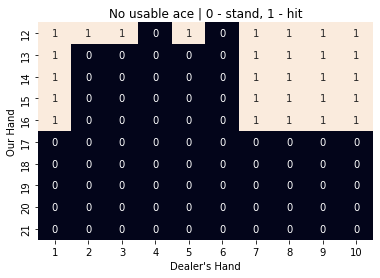

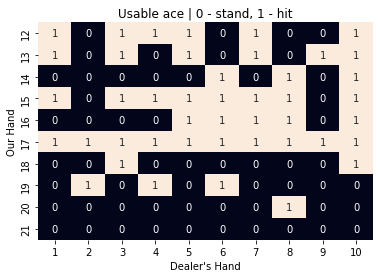

In [ ]:
sns.heatmap(
    data = np.argmax(agent.quality_table[12:22, 1:, 0], axis=2),
    cbar = False,
    annot = True,
    xticklabels = np.arange(1, 11),
    yticklabels = np.arange(12, 22)
)
plt.title("No usable ace | 0 - stand, 1 - hit")
plt.xlabel("Dealer's Hand")
plt.ylabel("Our Hand")
plt.show()

sns.heatmap(
    data = np.argmax(agent.quality_table[12:22, 1:, 1], axis=2),
    annot = True,
    cbar = False,
    xticklabels = np.arange(1, 11),
    yticklabels = np.arange(12, 22)
)
plt.title("Usable ace | 0 - stand, 1 - hit")
plt.xlabel("Dealer's Hand")
plt.ylabel("Our Hand")
plt.show()